In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import pandas as pd
from lsst.sims.photUtils import Bandpass
import lsst.syseng.throughputs as st

In [2]:
defaultDirs = st.setDefaultDirs()
defaultDirs

{'detector': '/Users/lynnej/lsstRepos/syseng_throughputs/components/camera/detector/joint_minimum',
 'lens1': '/Users/lynnej/lsstRepos/syseng_throughputs/components/camera/lens1',
 'lens2': '/Users/lynnej/lsstRepos/syseng_throughputs/components/camera/lens2',
 'lens3': '/Users/lynnej/lsstRepos/syseng_throughputs/components/camera/lens3',
 'filters': '/Users/lynnej/lsstRepos/syseng_throughputs/components/camera/filters',
 'mirror1': '/Users/lynnej/lsstRepos/syseng_throughputs/components/telescope/mirror1',
 'mirror2': '/Users/lynnej/lsstRepos/syseng_throughputs/components/telescope/mirror2',
 'mirror3': '/Users/lynnej/lsstRepos/syseng_throughputs/components/telescope/mirror3',
 'atmosphere': '/Users/lynnej/lsstRepos/syseng_throughputs/siteProperties'}

In [3]:
# Read the non-mirror components
detector = st.buildDetector(defaultDirs['detector'])
lens1 = st.buildLens(defaultDirs['lens1'])
lens2 = st.buildLens(defaultDirs['lens2'])
lens3 = st.buildLens(defaultDirs['lens3'])
filters = st.buildFilters(defaultDirs['filters'])
atmos = st.readAtmosphere(defaultDirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')

In [4]:
# We need a silver mirror and an aluminum mirror
os.listdir(defaultDirs['mirror1']), os.listdir(defaultDirs['mirror2']), os.listdir(defaultDirs['mirror3'])

(['m1_ProtAl_Ideal.dat', 'm1_Losses'],
 ['m2_Losses', 'm2_ProtAg_Ideal.dat'],
 ['m3_Losses', 'm3_ProtAl_Ideal.dat'])

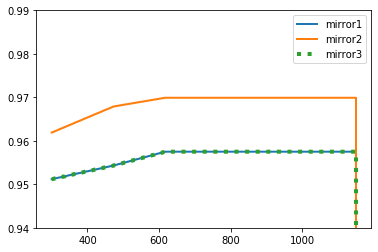

In [5]:
# check if mirror losses are the same ..
losses = {}
for m in ('mirror1', 'mirror2', 'mirror3'):
    losses[m] = Bandpass()
    losses[m].readThroughput(os.path.join(defaultDirs[m], '%s%s_Losses' % (m[0],m[-1]), 
                                          '%s%s_Losses.dat' % (m[0], m[-1])))
    linestyle = '-'
    width=2
    if m == 'mirror3':
        linestyle=':'
        width=4
    plt.plot(losses[m].wavelen, losses[m].sb, linestyle=linestyle, linewidth=width, label=m)
plt.ylim(0.94, 0.99)
plt.legend()

In [6]:
# Mirror losses are not the same (up vs. down-facing I think), so turn them off for now.
mirror = {}
mirror['Al'] = st.buildMirror(defaultDirs['mirror1'], addLosses=False)
mirror['Ag'] = st.buildMirror(defaultDirs['mirror2'], addLosses=False)
# BUT because they are not material dependent and just multiply by the mirror throughput .. 
# we can add them back anyway



In [7]:
# Ok .. 8 combos are actually 4 because it doesn't matter which order the mirrors are in.
combos = [['Al', 'Al', 'Al'], ['Al', 'Ag', 'Al'], ['Ag', 'Al', 'Ag'], ['Ag', 'Ag', 'Ag']]

m5 = {}
m5_badrd = {}
system_all = {}
for combo in combos:
    hardware = {}
    system = {}
    for f in filters:
        wavelen = detector.wavelen
        # Hardware
        sb = detector.sb * lens1.sb * lens2.sb * lens3.sb * filters[f].sb
        sb *= losses['mirror1'].sb * losses['mirror2'].sb * losses['mirror3'].sb
        sb *= mirror[combo[0]].sb * mirror[combo[1]].sb * mirror[combo[2]].sb
        hardware[f] = Bandpass()
        hardware[f].setBandpass(wavelen, sb)
        system[f] = Bandpass()
        system[f].setBandpass(wavelen, sb * atmos.sb)
    system_all['-'.join(combo)] = system
    m5['-'.join(combo)] = st.makeM5(hardware, system)
    m5_badrd['-'.join(combo)] = st.makeM5(hardware, system, exptime=30, nexp=1, readnoise=18, 
                                          othernoise=0, darkcurrent=0.2)

In [8]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k', lw=4),
                Line2D([0], [0], color='k', lw=4),
                Line2D([0], [0], color='k', lw=4)]

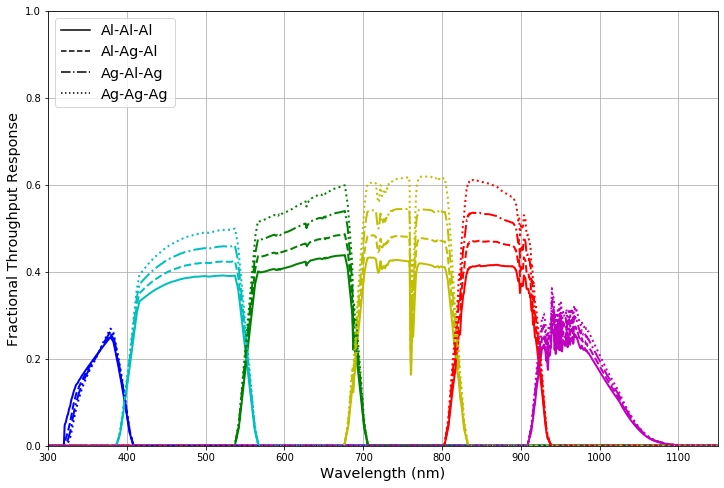

In [9]:
plt.figure(figsize=(12, 8))
linestyles = ['-', '--', '-.', ':']
leg_elements = []
for i, combo in enumerate(combos):
    label = '-'.join(combo)
    linestyle= linestyles[i]
    st.plotBandpasses(system_all['-'.join(combo)], newfig=False, addlegend=False, linestyle=linestyle)
    leg_elements.append(Line2D([0], [0], color='k', linestyle=linestyle, label=label))
plt.legend(handles=leg_elements, loc='upper left', fontsize='x-large', fancybox=True)

In [10]:
d = pd.DataFrame({'Al-Al-Al': m5['Al-Al-Al'].m5, 'Al-Ag-Al': m5['Al-Ag-Al'].m5,
                  'Ag-Al-Ag': m5['Ag-Al-Ag'].m5, 'Ag-Ag-Ag': m5['Ag-Ag-Ag'].m5})
d_badrd = pd.DataFrame({'Al-Al-Al': m5_badrd['Al-Al-Al'].m5, 'Al-Ag-Al': m5_badrd['Al-Ag-Al'].m5,
                  'Ag-Al-Ag': m5_badrd['Ag-Al-Ag'].m5, 'Ag-Ag-Ag': m5_badrd['Ag-Ag-Ag'].m5})
d

,Al-Al-Al,Al-Ag-Al,Ag-Al-Ag,Ag-Ag-Ag
u,23.898164,23.869611,23.853811,23.844936
g,24.772867,24.821949,24.870521,24.918597
r,24.299065,24.359139,24.418566,24.477384
i,23.859888,23.934198,24.007626,24.080256
z,23.291134,23.363197,23.434798,23.505984
y,22.424236,22.468393,22.512425,22.556341


In [11]:
delta_m5 = (d.T - d['Al-Ag-Al'].T)
delta_m5_badrd = d_badrd.T - d['Al-Ag-Al'].T
delta_m5 = delta_m5.T.join(delta_m5_badrd.T, rsuffix='_bdRd')
delta_m5
# Positive values mean deeper limiting magnitudes

,Al-Al-Al,Al-Ag-Al,Ag-Al-Ag,Ag-Ag-Ag,Al-Al-Al_bdRd,Al-Ag-Al_bdRd,Ag-Al-Ag_bdRd,Ag-Ag-Ag_bdRd
u,0.028553,0.0,-0.015800,-0.024674,-0.244929,-0.282077,-0.302792,-0.314721
g,-0.049082,0.0,0.048572,0.096648,-0.193940,-0.138516,-0.083716,-0.029537
r,-0.060074,0.0,0.059426,0.118245,-0.151830,-0.085388,-0.019910,0.044644
i,-0.074310,0.0,0.073428,0.146057,-0.145304,-0.064066,0.015748,0.094237
z,-0.072063,0.0,0.071601,0.142787,-0.121599,-0.044859,0.031041,0.106166
y,-0.044157,0.0,0.044032,0.087948,-0.081344,-0.034802,0.011480,0.057518


In [12]:
# Effective time calculation
# Fractional change in effective time is proportional to change in m5.
dtime = np.power(10, -0.8 * (delta_m5))
dtime

,Al-Al-Al,Al-Ag-Al,Ag-Al-Ag,Ag-Ag-Ag,Al-Al-Al_bdRd,Al-Ag-Al_bdRd,Ag-Al-Ag_bdRd,Ag-Ag-Ag_bdRd
u,0.948763,1.0,1.029532,1.046500,1.570158,1.681365,1.746762,1.785569
g,1.094626,1.0,0.914414,0.836916,1.429395,1.290662,1.166736,1.055917
r,1.117016,1.0,0.896312,0.804275,1.322708,1.170336,1.037356,0.921054
i,1.146695,1.0,0.873489,0.764107,1.306903,1.125259,0.971408,0.840641
z,1.141958,1.0,0.876433,0.768724,1.251063,1.086144,0.944425,0.822370
y,1.084740,1.0,0.922093,0.850435,1.161649,1.066206,0.979074,0.899467


In [13]:
SRD_time_distribution = pd.Series({'u': 0.068, 'g': 0.097, 'r': 0.223, 'i': 0.223, 'z': 0.194, 'y': 0.194})
SRD_time_distribution 

u    0.068
g    0.097
r    0.223
i    0.223
z    0.194
y    0.194
dtype: float64

In [14]:
weighted_dtime = dtime.multiply(SRD_time_distribution, axis=0)
weighted_dtime

,Al-Al-Al,Al-Ag-Al,Ag-Al-Ag,Ag-Ag-Ag,Al-Al-Al_bdRd,Al-Ag-Al_bdRd,Ag-Al-Ag_bdRd,Ag-Ag-Ag_bdRd
u,0.064516,0.068,0.070008,0.071162,0.106771,0.114333,0.118780,0.121419
g,0.106179,0.097,0.088698,0.081181,0.138651,0.125194,0.113173,0.102424
r,0.249095,0.223,0.199878,0.179353,0.294964,0.260985,0.231330,0.205395
i,0.255713,0.223,0.194788,0.170396,0.291439,0.250933,0.216624,0.187463
z,0.221540,0.194,0.170028,0.149132,0.242706,0.210712,0.183218,0.159540
y,0.210440,0.194,0.178886,0.164984,0.225360,0.206844,0.189940,0.174497


In [15]:
weighted_dtime.sum()

Al-Al-Al         1.107482
Al-Ag-Al         0.999000
Ag-Al-Ag         0.902286
Ag-Ag-Ag         0.816209
Al-Al-Al_bdRd    1.299891
Al-Ag-Al_bdRd    1.169001
Ag-Al-Ag_bdRd    1.053066
Ag-Ag-Ag_bdRd    0.950737
dtype: float64

In [16]:
np.round((weighted_dtime.sum() * 10 * 365.25 - 3652.5) * 800)

Al-Al-Al         314061.0
Al-Ag-Al          -2922.0
Ag-Al-Ag        -285520.0
Ag-Ag-Ag        -537038.0
Al-Al-Al_bdRd    876283.0
Al-Ag-Al_bdRd    493820.0
Ag-Al-Ag_bdRd    155060.0
Ag-Ag-Ag_bdRd   -143947.0
dtype: float64